In [1]:
%pylab inline
import numpy as np
import keras, os, pynbody, struct

lsstr = "ls /media/xiaodongli/0B9ADFB4341AD2BD/om_As/"

def cosmostr(om, As):
    return 'om%.3f' % om + '_As%.3f' % As

def snpfiles(cosmology, snpstr='c'):  #
    return os.popen(lsstr + cosmology + "*snap*" + snpstr + ".*").read().split()

def gridfiles(cosmology, snpstr='c'):
    return os.popen(lsstr + cosmology + "*grid*" + snpstr + ".*").read().split()

def mocklist():
    files = os.popen(lsstr + "om*.lua").read().split('\n')
    # *代替多个字母,即列出所有符合条件的.lua文件:om...
    cosmologies = []  # 宇宙学参数
    mocks = {}  # 模拟测试
    ifile = 0  # 有效文件
    for nowfile in files:
        # str[a:b]不存在时,返回'',不存在则忽略
        nowstr = nowfile[-39:-10]
        if nowstr == '':
            continue
        cosmologies.append(nowstr[0:15])
        ifile += 1
        try:
            mocks[nowstr[0:15]] = {'om': float(nowstr[2:7]), 'As': float(nowstr[10:15]),
                                   'sigma8': float(nowstr[23:29])}
            # 添加随机数种子
            ranseed = float(open(nowfile, 'r').readline().split()[2])  # 默认以所有空字符为分隔符,包括空格,\n,\t
            mocks[nowstr[0:15]]['ranseed'] = int(ranseed)
            # print(ranseed)
        except:
            pass
    return cosmologies, files, mocks

gridfile_dict = {}

cosmologies, filenames, infos = mocklist()
print('In total ', len(cosmologies), 'cosmologies')

print('Build up gridfile_dict... (for speed-up of load_grid()) ')
for cosmology in cosmologies:
    rlt = gridfiles(cosmology)
    if rlt == []:
        print ('\tmissing cosmology!', cosmology)
    else:
        gridfile_dict[cosmology] = rlt[0]
np.random.shuffle(cosmologies)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In total  0 cosmologies
Build up gridfile_dict... (for speed-up of load_grid()) 


# Plot filed

0.16 2.0 0.4252
0.26 2.16 0.719
0.36 2.0 0.8863


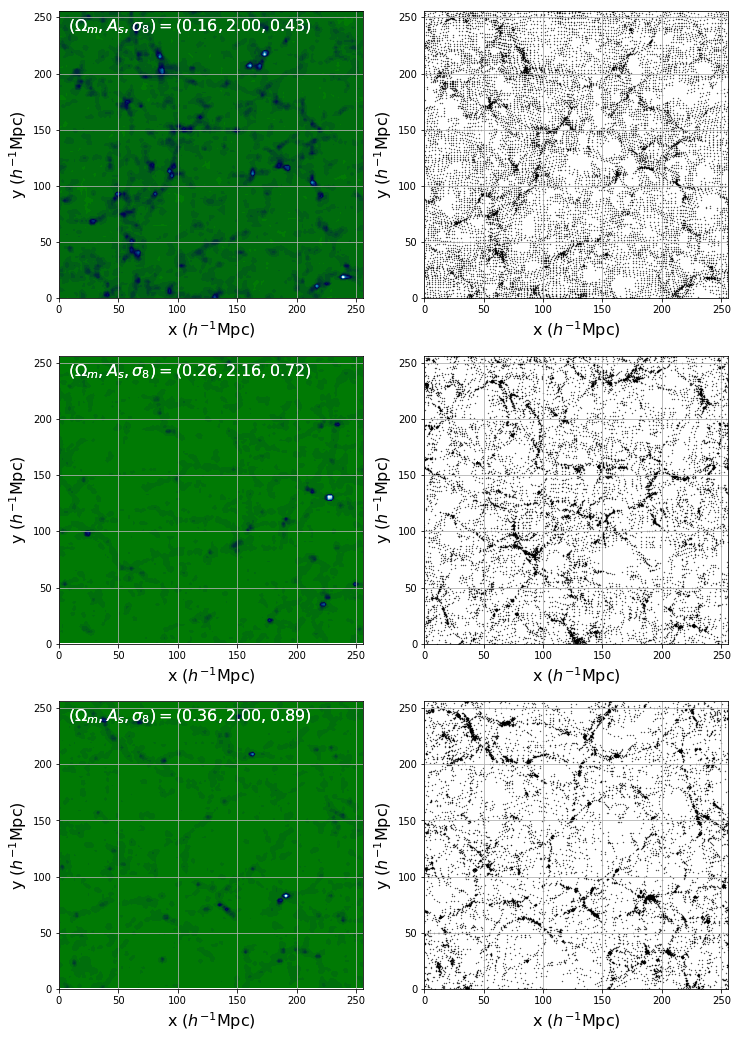

In [2]:
def load_grid(gridfile, snpstr='c', printinfo=False):  # 网格加载
    gridfile = os.popen(lsstr + "om%.3f" % om + "_As2.000_sigma8_*grid*" + snpstr + ".*").read().split()[0]
    nowf = open(gridfile, 'rb')  # 以二进制形式读取文件
    # struct:对python基本类型值与用python字符串格式表示的C struct类型间转化
    size = struct.unpack('f' * 1, nowf.read(4 * 1))[0]
    grid_nc = struct.unpack('i' * 1, nowf.read(4 * 1))[0]
    data = struct.unpack('f' * grid_nc ** 3, nowf.read(4 * grid_nc ** 3))
    if printinfo:
        print('read in box size     \n\t', size)
        print('read in num_grid      \n\t', grid_nc)
        print('read in coarse grid \n\tsize    : ', len(data), '\n\texpect  : ', grid_nc ** 3)

    nowf.close()
    return np.array(data).reshape((grid_nc, grid_nc, grid_nc))

def values_from_filename(filename):
    for row in range(len(filename)):
        if filename[row:row+2] == 'om':
            if filename[row+2] not in ['0', '1', '-', ]:
                continue
            else:
                om = float(filename[row+2:row+7])
        elif filename[row:row+2] == 'As':
            if filename[row+2] not in ['2', '1', '3', ]:
                continue
            else:
                As = float(filename[row+2:row+7])
        elif filename[row:row+3] == 'sig':
            sig8 = float(filename[row+7:row+13])
    return om, As, sig8

size=256

fig, axs = subplots(3, 2, figsize=(12, 18))
iom = 0
for om in [0.16, 0.26, 0.36]:
    
    ax1, ax2 = axs[iom]; iom+=1
    
    cosmology = cosmostr(om, 2.0)
    if om== 0.26:
        cosmology = cosmostr(om, 2.16)
    
    filename = gridfile_dict[cosmology]
    om, As, sig8 = values_from_filename(filename)
    print(om, As, sig8)
    
    # plot grid
    data = load_grid(cosmology, 'c')
    ax1.contourf(np.linspace(1, 255, 128), np.linspace(1, 255, 128), data[:, :, 0].T, 30, cmap='ocean')

    # plot snp
    pos = []
    for snpfile in snpfiles(cosmology, 'c'):
        data = pynbody.load(snpfile)['pos']
        pos.append(np.copy(data[where(data[:, 2] < 2.)]))
    pos = np.concatenate(pos)

    ax2.scatter(pos[:, 0], pos[:, 1], s=0.1, c='k', alpha=1)
    for ax in [ax1, ax2]:
        ax.grid(); 
        ax.set_xlabel('x ($h^{-1} \\rm Mpc$)', fontsize=16)
        ax.set_ylabel('y ($h^{-1} \\rm Mpc$)', fontsize=16)
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax1.text(size * 0.03, size * 0.93, 
                 r'$(\Omega_m, A_s, \sigma_8) = (%.2f'%om+', %.2f'%As+', %.2f'%sig8+')$', 
                 fontsize=16, color='white')
plt.show()
fig.savefig('./draft/field.eps', format='eps')

# Plot architecture

In [3]:
model = keras.models.load_model('./src/epochs_test/500.save')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [4]:
import pydot

In [5]:
from pydot import *

In [19]:
keras.utils.vis_utils.plot_model(model, to_file='./src/epochs_test_300.save.png', show_shapes=True, show_layer_names=False)
!eog ./src/epochs_test_300.save.png
#fig, ax = subplots()
#ax.imshow('./src/epochs_test_300.save.png')

In [16]:
data

In [7]:
import odo

/home/xiaodongli/software/anaconda3/lib/python3.7/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [12]:
import pydot
import keras, os, pynbody, struct

In [23]:
4./6.

0.6666666666666666

In [165]:
64*(3**3)*32+64

55360

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32, 32, 32, 1)     4         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 30, 32)    896       
_________________________________________________________________
average_pooling3d_1 (Average (None, 15, 15, 15, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 15, 32)    128       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 13, 13, 13, 64)    55360     
_________________________________________________________________
average_pooling3d_2 (Average (None, 6, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 6, 6, 64)       256       
__________

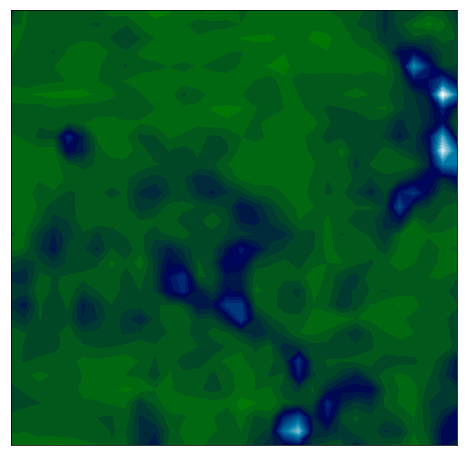

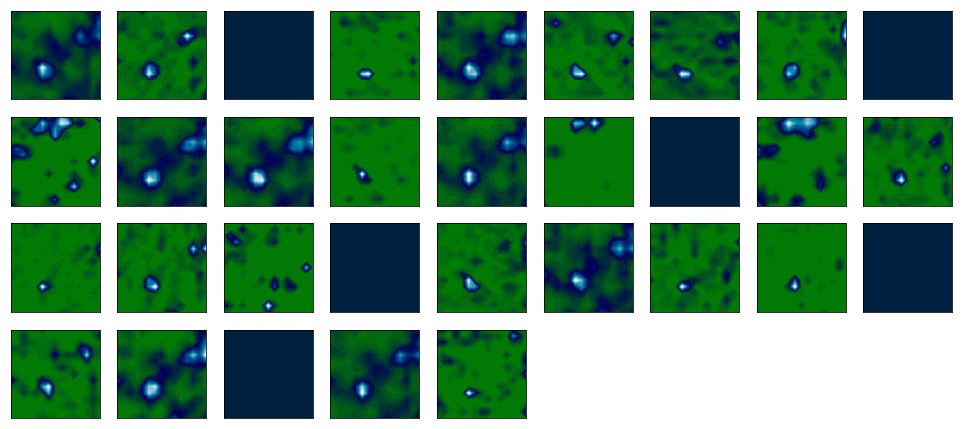

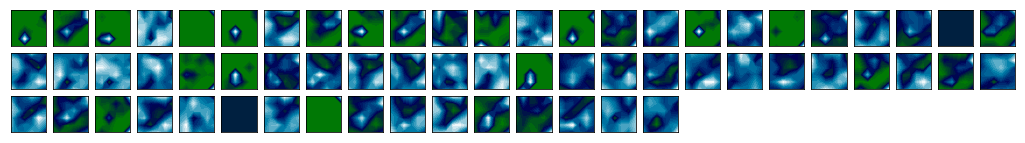

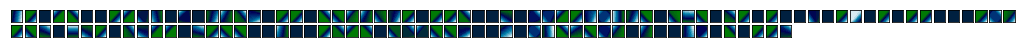

In [136]:
fig, axs = plot_layer_output(input_sample, figsize=8)
fig.savefig('layeroutput_0.esp', format='eps')

iplot = 0
figsizes = [15/8., 6/8., 2/8.]
for ilayer in [2,5,8]:
    model_frac = keras.models.Model(inputs=model.input, outputs=model.layers[ilayer].output)
    outputs = model_frac.predict(input_sample)
    fig, axs = plot_layer_output(outputs, figsize=figsizes[iplot])
    fig.savefig('layeroutput_'+str(iplot)+'.esp', format='eps')
    iplot += 1

######
 om, As, sig8 =  0.16 2.0 0.4252
predicted result: [[0.16135173 0.4502978 ]]


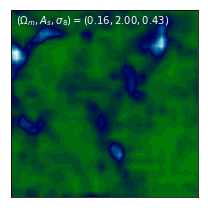

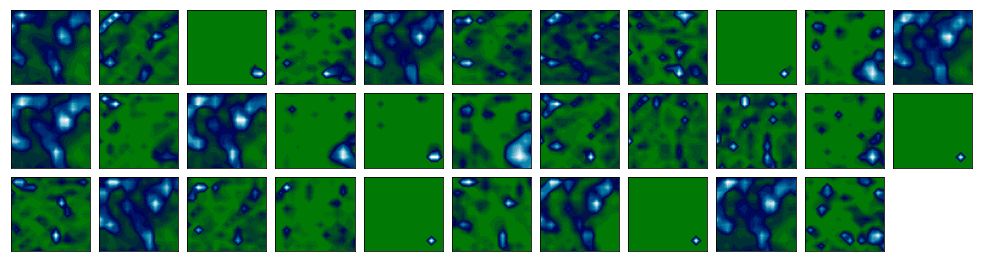

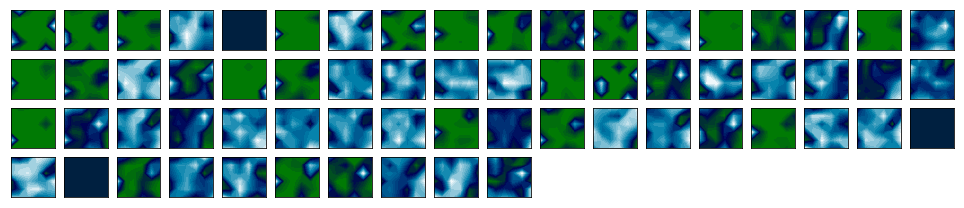

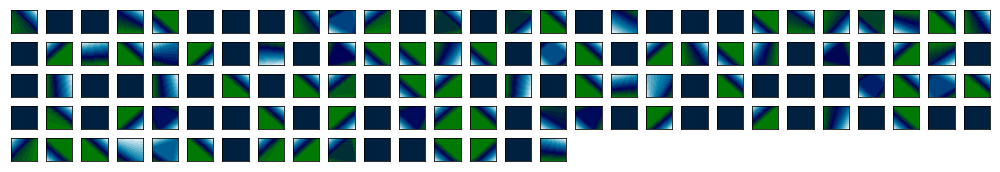

In [169]:
def subcubes(A):
    rlt = []
    for row1 in [0, 32, 64, 96]:
        for row2 in [0, 32, 64, 96]:
            for row3 in [0, 32, 64, 96]:
                rlt.append(A[row1:row1+32,row2:row2+32,row3:row3+32])
    return rlt

def plot_layer_output(outputs, figsize=4):
    nax = len(outputs[0,0,0,0,:]); ngrid = int(14 / figsize)
    if nax <=ngrid:
        nrow =1; ncol = nax
    else:
        ncol=ngrid; nrow = int(nax / ncol+0.999)
    fig, axs = subplots(nrow, ncol, figsize=(ncol*figsize, nrow*figsize)); 
    try:
        axs = axs.reshape(-1)
    except:
        axs = [axs]
    for row in range(nax):
        output_plot = outputs[0,:,:,0,row]
        axs[row].contourf(np.linspace(0,1,len(output_plot)), np.linspace(0,1,len(output_plot)), output_plot.T, 30, cmap='ocean')
        axs[row].set_xticks([]);axs[row].set_yticks([]);
    for row in range(nax, len(axs)):
        axs[row].set_visible(False)
    return fig, axs

icosmology = 0

for om in [0.16]:#, 0.26, 0.36]:
    
    cosmology = cosmostr(om, 2.0)
    if om== 0.26:
        cosmology = cosmostr(om, 2.16)
    
    filename = gridfile_dict[cosmology]
    om, As, sig8 = values_from_filename(filename)
    print('######\n om, As, sig8 = ', om, As, sig8)
    
    # plot grid
    data = load_grid(cosmology, 'c')
    input_sample = subcubes(data)[0].reshape(-1,32,32,32,1)
    
    if om == 0.16:
        input_sample = subcubes(data)[10].reshape(-1,32,32,32,1)
    
    print('predicted result:', model.predict(input_sample))
    fig, axs = plot_layer_output(input_sample, figsize=3)
    axs[0].text( 0.03, 0.93, 
                 r'$(\Omega_m, A_s, \sigma_8) = (%.2f'%om+', %.2f'%As+', %.2f'%sig8+')$', 
                 fontsize=10, color='white', transform=axs[0].transAxes,)
    fig.tight_layout(h_pad = 0.2, w_pad = 0.2)
    fig.savefig('draft/layeroutput_'+str(icosmology)+'0.eps', format='eps')

    iplot = 0
    figsizes = [10/8., 6/8., 4/8.]
    for ilayer in [2,5,8]:
        model_frac = keras.models.Model(inputs=model.input, outputs=model.layers[ilayer].output)
        outputs = model_frac.predict(input_sample)
        fig, axs = plot_layer_output(outputs, figsize=figsizes[iplot])
        fig.tight_layout(h_pad = 0.2, w_pad = 0.2)
        fig.savefig('draft/layeroutput_'+str(icosmology)+str(iplot+1)+'.eps', format='eps')
        iplot += 1
    icosmology += 1